# Filament initialization in a sphere

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import math
rng = np.random.default_rng() # initialize generator instance
from mpl_toolkits import mplot3d # for vizualization
%matplotlib notebook

This is a filament initializer that places the center points of filaments inside a sphere. If a constant director is chosen, this can lead to a tactoid-like configuration of filaments.

Author: Saad J. Ansari (2020)

In [41]:
# Define some constants
R = 0.08 # radius of sphere (micron)
vol_sphere = (4/3) * math.pi * R**3
n_fil = 100;
use_pack_frac = False
pack_frac = 0.3 # packing fraction (volume of filaments inside sphere/total volume of sphere)

D = 0.007 # diameter of filaments (micron)
director = np.array([0, 0, 1]) # director vector (CAN BE RANDOMIZED)
Lmin = 0.09 # minimum length of filaments
Lmax = 0.28 # maximum length of filaments
Lmean = 0.18 # mean length of filaments
use_exp_filament_length = True # flag to sample from an exponential distribution of lengths (cutoff with Lmin and Lmax)

fname = './TubuleInitial_n100_poly.dat'
write_file = True
run_visualization = True
run_tests = False
system_offset = [1,1,1]

### Description:

We do this in the following way:
* Randomly sample $(x,y,z)$ where $x,y,z \in [-R,R]$ such that $x^2 + y^2 + z^2 < R^2$
* Attempt to add a filament at the sampled position:
    * Check for minimum distance to all pre-existing filaments.
    * If minimum distance is less than the filament diameter $D$, a filament instance is created and **successfully added** to a filament list.
    * If minimum distance condition is not met, the filament is **not added** to the list.
    * If a filament is added successfully, we continue. Otherwise, we sample another point and attempt a filament addition before proceeding.
* Once a filament is added, we calculate the a packing fraction for the system (if enabled).
* The steps above are repeated. The program stops when:
    * The specified number of filaments are attained, or an addition attempt fails 5000 consecutive times.
    * The specified packing fraction is attained (if enabled)

We begin by creating the machinery to achieve this.

1. **Filament( )** (class): Useful way to store information (start pt, end pt, gid, length, director) about a given filament. The choice of a class is natural when multiple instances need to be created.


2. **minDistBetweenTwoFil( )**: Calculates the minimum distance between two filaments. It parametrizes the filaments with $(s,t)$ and seeks a global minimum of $W(s,t)$, the squared distance between any two points on the two lines. If the global minimum lies outside the range of $s$ and $t$ ($s \in [0,1]$, $t \in [0,1]$), then it checks all the edges for a minimum distance. It works for both parallel and non-parallel, overlapping and skew filaments. This is adapted from http://softsurfer.com/Archive/algorithm_0106/algorithm_0106.htm#dist3D_Segment_to_Segment.


3. **minDistFilAll( )**: Calcutes the minimum distance between a single filament and a list of filaments. It loops over all filaments in the list and uses *minDistBetweenTwoFil()* to evaluate pair-pair distances. 


4. **getLengthRandomExp( )**: samples a value from an exponential distribution with min and max cutoffs for the values. We use this to sample filament lengths if enabled.


5. **sph2cart**/**cart2sph**:  transformations between cartesian and spherical coordinates.


6. **getFilamentLengthInsideSphere( )**: finds the length of a filament that lies inside a spherical region. It does that by getting points along a filament and checking their radial coordinate (in the spherical coordinate system). This gives an enclosed length of a filament which can be used to calculate an enclosed volume.

7. **getRand3PointInSphere( )**: get a random point in 3D space that is inside the sphere of some specified radius.

### Notes:

* The packing fraction calculation uses the value inside the initialization sphere. We assume that this is an accurate representation of the packing fraction throughout the system.
* The code can be easily modified to get an isotropic initial condition (randomly sample the director vector)

### Code:

In [27]:
# Define a filament class
class Filament():
    def __init__(self, center, director, leng, radius):
        self.center = center
        self.director = director/ np.linalg.norm(director)
        self.length = leng
        self.radius = radius
        self.pos_start = center - leng/2 * self.director
        self.pos_end = center + leng/2 * self.director
        self.gid = gid # defined outisde the class
    def Plot3(self,ax):
        ax.plot3D( [self.pos_start[0], self.pos_end[0]], [self.pos_start[1], self.pos_end[1]], [self.pos_start[2], self.pos_end[2]], 'red')
    def GetStringtoWrite(self):
        return 'C {0} {1} {2:0.6f} {3:0.6f} {4:0.6f} {5:0.6f} {6:0.6f} {7:0.6f}\n'.format(
        self.gid, self.radius,
        self.pos_start[0], self.pos_start[1], self.pos_start[2],
        self.pos_end[0], self.pos_end[1], self.pos_end[2])
    def __repr__(self):
        return "Filament()"
    def __str__(self):
        return 'Filament {0}:\n  pos_start: {1}\n  pos_end: {2}\n  length: {3}\n  radius: {4}'.format(self.gid, self.pos_start, self.pos_end, self.length,self.radius)

In [28]:
# Find Minimum Distance between two filaments
def minDistBetweenTwoFil(f1, f2):
    # Adapted from matlab
    # https://www.mathworks.com/matlabcentral/fileexchange/32487-shortest-distance-between-two-line-segments
    # which adapted this from Dan Sunday's Geometry Algorithms originally written in C++
    # http://softsurfer.com/Archive/algorithm_0106/algorithm_0106.htm#dist3D_Segment_to_Segment
    
    # p1 = f1.pos_start
    # p2 = f1.pos_end
    # p3 = f2.pos_start
    # p4 = f2.pos_end
    # Computes the minimum distance between two line segments. Code
    # is adapted for Matlab from Dan Sunday's Geometry Algorithms originally
    # written in C++
    # http://softsurfer.com/Archive/algorithm_0106/algorithm_0106.htm#dist3D_Segment_to_Segment
    # Usage: Input the start and end x,y,z coordinates for two line segments. 
    # p1, p2 are [x,y,z] coordinates of first line segment and p3,p4 are for
    # second line segment. 
    # Output: scalar minimum distance between the two segments.
    #  Example:
    #	P1 = [0 0 0];     P2 = [1 0 0];
    #   P3 = [0 1 0];     P4 = [1 1 0];
    #	dist = minDistBetweenTwoFil(P1, P2, P3, P4)
    p1 = f1.pos_start
    p2 = f1.pos_end
    p3 = f2.pos_start
    p4 = f2.pos_end
    
    u = p1 - p2
    v = p3 - p4
    w = p2 - p4
    
    a = np.dot(u,u)
    b = np.dot(u,v)
    c = np.dot(v,v)
    d = np.dot(u,w)
    e = np.dot(v,w)
    D = a*c - b*b
    sD = D
    tD = D
    
    SMALL_NUM = 0.00000001
    
    # compute the line parameters of the two closest points
    if D < SMALL_NUM: # the lines are almost parallel
        sN = 0.0     # force using point P0 on segment S1
        sD = 1.0     # to prevent possible division by 0.0 later
        tN = e
        tD = c
    else:             # get the closest points on the infinite lines
        sN = (b*e - c*d)
        tN = (a*e - b*d)
        if sN < 0.0:   # sc < 0 => the s=0 edge is visible       
            sN = 0.0
            tN = e
            tD = c
        elif sN > sD:  # sc > 1 => the s=1 edge is visible
            sN = sD
            tN = e + b
            tD = c
    
    if tN < 0.0:            # tc < 0 => the t=0 edge is visible
        tN = 0.0
        # recompute sc for this edge
        if -d < 0.0:
            sN = 0.0
        elif -d > a:
            sN = sD
        else:
            sN = -d
            sD = a
    elif tN > tD:       # tc > 1 => the t=1 edge is visible
        tN = tD
        # recompute sc for this edge
        if -d + b < 0.0:
            sN = 0
        elif -d + b > a:
            sN = sD
        else: 
            sN = -d + b
            sD = a
    
    # finally do the division to get sc and tc
    if  np.absolute(sN) < SMALL_NUM:
        sc = 0.0
    else:
        sc = sN / sD
    
    if np.absolute(tN) < SMALL_NUM:
        tc = 0.0
    else:
        tc = tN / tD
    
    # get the difference of the two closest points
    dP = w + (sc * u) - (tc * v);  # = S1(sc) - S2(tc)
    distance = np.linalg.norm(dP);
    outV = dP;
    
    # outV = outV      # vector connecting the closest points
    # cp_1 = p2+sc*u  # Closest point on object 1 
    # cp_2 = p4+tc*v  # Closest point on object 2
    
    return distance

In [29]:
# Define a Minimum Distance from one filament to all other filaments
def minDistFilAll( f1, f_list):
    dists = [ minDistBetweenTwoFil(f1,f2) for f2 in f_list]
    if not dists:
        return 1e6
    else:
        return np.min(dists)

In [30]:
# Define a random length sampler
def getLengthRandomExp( rng, Lmean, Lmin=0, Lmax=1e6):
    val = -1
    while val < Lmin or val > Lmax:
        val = rng.exponential( Lmean)
    return val

In [31]:
# polar to cartesian coordinates
def sph2cart(r, phi, theta):
    return np.array([
         r * math.sin(theta) * math.cos(phi),
         r * math.sin(theta) * math.sin(phi),
         r * math.cos(theta)
    ])
# cartesian to polar coordinates
def cart2sph(x, y, z):
    XsqPlusYsq = x**2 + y**2
    r = math.sqrt(XsqPlusYsq + z**2)               # r
    elev = math.atan2(z,math.sqrt(XsqPlusYsq))     # theta
    az = math.atan2(y,x)                           # phi
    return np.array([r, az, elev])

In [32]:
# volume of filament inside sphere
def getFilamentLengthInsideSphere(f1, rad):
    
    # Find coordinates along the filament whose r coord in (r,phi, theta) lies inside the sphere.
    # Segment the filament into 100 points
    lens = np.linspace(0, f1.length, 100)
    num_in = 0
    for el in lens:
        [x,y,z] = f1.pos_start + el*f1.director
        pt = cart2sph(x,y,z)
        if pt[0] < rad:
            num_in += 1
        
    return (num_in/100)*f1.length

In [33]:
# Get random 3d cartesian point() inside sphere
def getRand3PointInSphere(rad):
    d = 2*rad
    while d > rad:
        xyz = rng.uniform(-rad, rad, 3)
        d = np.linalg.norm(xyz)
    return [xyz[0],xyz[1],xyz[2]]

#    radius = np.random.uniform(0.0,1.0)*rad 
#    theta = np.random.uniform(-1.0,1.0)*math.pi
#    phi = np.arccos(1-2*np.random.uniform(0.0,1.))
#    x = radius * np.sin( theta ) * np.cos( phi )
#    y = radius * np.sin( theta ) * np.sin( phi )
#    z = radius * np.cos( theta )
#    return [x,y,z]

We start with a sphere with radius R. We randomly pick values (r,phi, theta) that define the position of a point in 3D space. We attempt to insert a filament with that point as its center. If the minimum distance between this filament and any other filaments is greater than diameter D of the filaments (i.e filaments do not overlap), we successfully complete the insertion. If insertion fails, we try a new point.

In [42]:
def attemptAddFilament(center, L, director, D, f_list, gid):
    # Initialize a  filament of length L
    fil = Filament(center, director, L, D/2)
    
    # find minimum distance to other filaments, and accept if distance is more than filament diameter
    min_dist = minDistFilAll(fil, f_list)
    status = False
    if min_dist > D:
        f_list.append(fil)
        gid+=1
        print(fil)
        status = True
    return f_list,gid,status

# There are two ways to go about this.
# 1. Attempt to achieve a specified packing fraction
# 2. Attempt to initialize a specified number of rods

gid = 0
f_list = [] # list to store filaments
if use_pack_frac:
    
    v_enclosed = 0 # volume occupied by filaments inside the sphere
    cpf = 0 # current packing fraction tracker
    while cpf < pack_frac:
        center = getRand3PointInSphere(R) # Sample a random (x,y,z inside a sphere)
        
        if use_exp_filament_length:
            L = getLengthRandomExp( rng, Lmean, Lmin, Lmax)
        else:
            L = Lmean
            
        f_list,gid,status = attemptAddFilament(center,L,director, D, f_list, gid)
        if status:
            len_inside = getFilamentLengthInsideSphere( f_list[-1], R) # length of filament inside the sphere
            v_enclosed += math.pi * (D/2)**2 * len_inside # volume of filament inside the sphere
            cpf = v_enclosed / vol_sphere # current packing fraction
            print('CPF = {}'.format(cpf))

    
else:
    
    # sample n_fil length values and sort them
    if use_exp_filament_length:
        lens = sorted( [getLengthRandomExp( rng, Lmean, Lmin, Lmax) for i in range(n_fil)], reverse=True)
    else:
        lens = [Lmean for i in range(n_fil)]
        
    for idx,el in enumerate(lens):
        status = False
        failCount=0
        while not status:
            failCount+=1
            center = getRand3PointInSphere(R) # Sample a random (x,y,z inside a sphere)
            f_list,gid,status = attemptAddFilament(center, el, director, D, f_list, gid)
            if failCount > 5000:
                raise Exception('Failed to add a filament with 5000 trials.\nStopping...\n...\n...\n Total Added Filaments = {}'.format(len(f_list)))

Filament 0:
  pos_start: [ 0.06122514  0.0345809  -0.14507805]
  pos_end: [0.06122514 0.0345809  0.12408577]
  length: 0.26916382450209575
  radius: 0.0035
Filament 1:
  pos_start: [-0.03027688 -0.03905017 -0.17385394]
  pos_end: [-0.03027688 -0.03905017  0.08377839]
  length: 0.2576323295190103
  radius: 0.0035
Filament 2:
  pos_start: [-0.01235409  0.02196374 -0.14754622]
  pos_end: [-0.01235409  0.02196374  0.10614322]
  length: 0.25368944671161814
  radius: 0.0035
Filament 3:
  pos_start: [ 0.05770114 -0.00289794 -0.1579199 ]
  pos_end: [ 0.05770114 -0.00289794  0.09520309]
  length: 0.25312299505702013
  radius: 0.0035
Filament 4:
  pos_start: [-0.03487532  0.02856318 -0.16282528]
  pos_end: [-0.03487532  0.02856318  0.08849697]
  length: 0.2513222536657738
  radius: 0.0035
Filament 5:
  pos_start: [ 0.00366694 -0.02460326 -0.08669341]
  pos_end: [ 0.00366694 -0.02460326  0.16322515]
  length: 0.24991855984249126
  radius: 0.0035
Filament 6:
  pos_start: [ 0.00937439 -0.00475317 -

  radius: 0.0035
Filament 67:
  pos_start: [-0.00676948  0.03260591 -0.07111   ]
  pos_end: [-0.00676948  0.03260591  0.04713635]
  length: 0.1182463548364145
  radius: 0.0035
Filament 68:
  pos_start: [ 0.01629221 -0.03779712 -0.00741175]
  pos_end: [ 0.01629221 -0.03779712  0.10802603]
  length: 0.11543778367865914
  radius: 0.0035
Filament 69:
  pos_start: [ 0.03471465  0.04239435 -0.05707249]
  pos_end: [0.03471465 0.04239435 0.05767688]
  length: 0.11474936816828715
  radius: 0.0035
Filament 70:
  pos_start: [ 0.00712999 -0.0392521  -0.02689588]
  pos_end: [ 0.00712999 -0.0392521   0.08750115]
  length: 0.1143970224028063
  radius: 0.0035
Filament 71:
  pos_start: [ 0.00068206 -0.00390882 -0.00474917]
  pos_end: [ 0.00068206 -0.00390882  0.10914587]
  length: 0.11389503491853877
  radius: 0.0035
Filament 72:
  pos_start: [-0.01154462 -0.02136449 -0.05763301]
  pos_end: [-0.01154462 -0.02136449  0.05568026]
  length: 0.1133132675329005
  radius: 0.0035
Filament 73:
  pos_start: [-0

### Visualization:

<IPython.core.display.Javascript object>


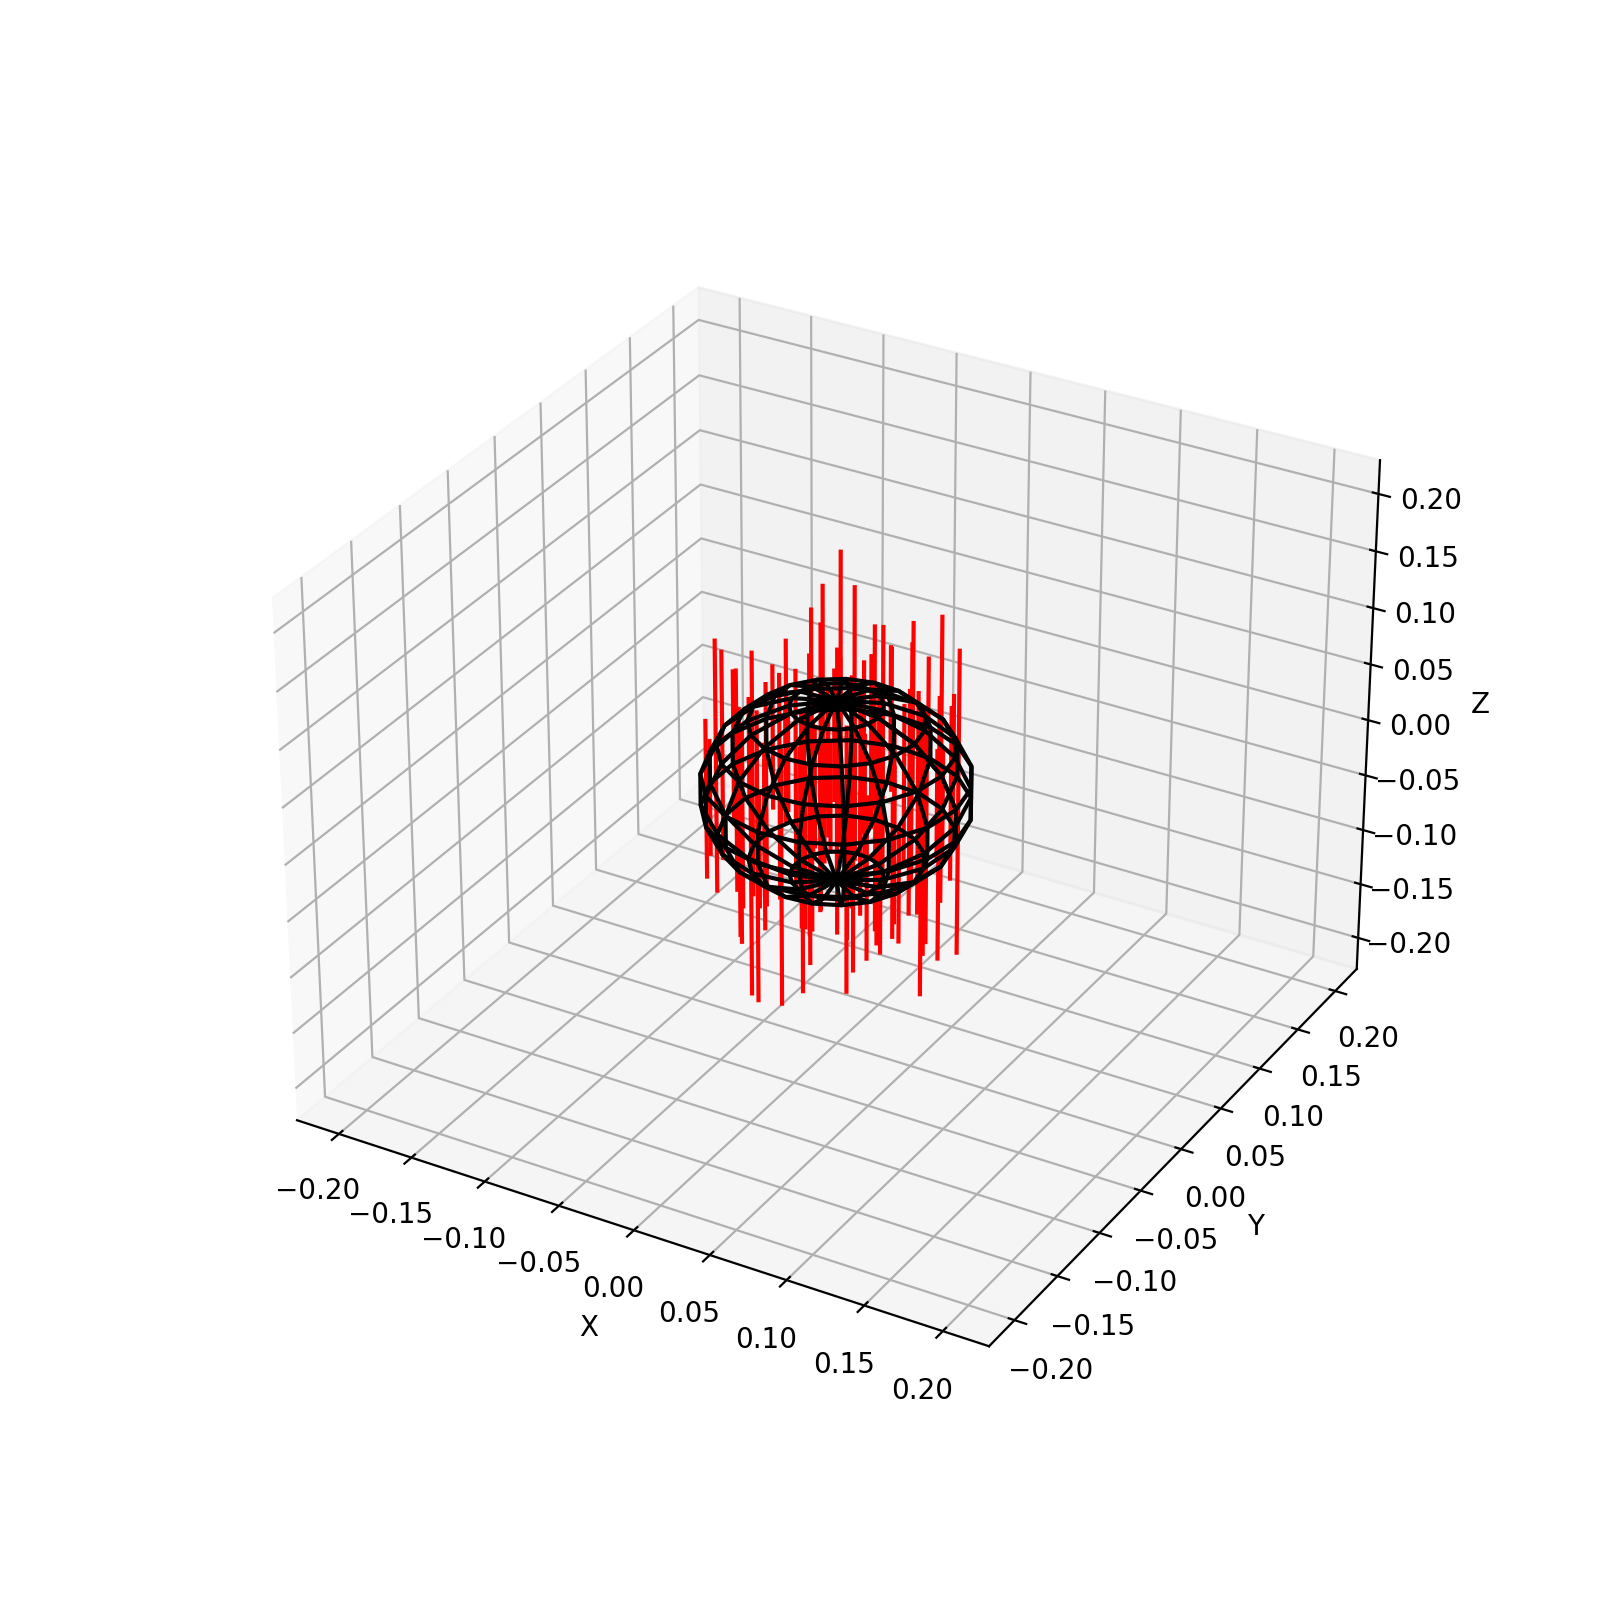

In [43]:
if run_visualization:
    %matplotlib notebook
    fig = plt.subplots(figsize=(8,8))
    ax = plt.axes(projection='3d')

    # Plot filaments
    for fil in f_list:
        fil.Plot3(ax)

    # Plot sphere wireframe
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = R*np.cos(u)*np.sin(v)
    y = R*np.sin(u)*np.sin(v)
    z = R*np.cos(v)
    ax.plot_wireframe(x, y, z, color="black")

    ax.set_xlim3d(-R-Lmax/2, R+Lmax/2)
    ax.set_ylim3d(-R-Lmax/2, R+Lmax/2)
    ax.set_zlim3d(-R-Lmax/2, R+Lmax/2)
    ax.set(xlabel='X', ylabel='Y', zlabel='Z')

In [44]:
if write_file:
    
    # first offset system
    for fil in f_list:
        fil.pos_start += np.array(system_offset)
        fil.pos_end += np.array(system_offset)
        fil.center += np.array(system_offset)
    filer = open(fname,"w")
    filer.write('# Initial configuration of rods\n#\n')
    for fil in f_list:
        filer.write( fil.GetStringtoWrite() )
    filer.close()

## Tests:

### Minimum distance function:

In [13]:
if run_tests:
    # parallel lines with separation 1 in X
    gid=0
    f1 = Filament([0,0,0], [0,0,1],2)
    f2 = Filament([1,0,0], [0,0,1],2)
    print('Expected Distance =   1.0\nCalculated Distance = {}\n'.format(minDistBetweenTwoFil(f1,f2)))

    # parallel lines with separation 1 in X and Y
    gid=0
    f1 = Filament([0,0,0], [0,0,1],2)
    f2 = Filament([1,0,1], [0,0,1],2)
    print('Expected Distance =   1.0\nCalculated Distance = {}\n'.format(minDistBetweenTwoFil(f1,f2)))

    # parallel overlapping lines with only endpoints touching
    gid=0
    f1 = Filament([0,0,0], [0,0,1],2)
    f2 = Filament([0,0,2], [0,0,1],2)
    print('Expected Distance =   0.0\nCalculated Distance = {}\n'.format(minDistBetweenTwoFil(f1,f2)))

    # parallel overlapping lines with one line inside another
    gid=0
    f1 = Filament([0,0,0], [0,0,1],1)
    f2 = Filament([0,0,0], [0,0,1],2)
    print('Expected Distance =   0.0\nCalculated Distance = {}\n'.format(minDistBetweenTwoFil(f1,f2)))

    # parallel lines with same XY and separated in Z by 1
    gid=0
    f1 = Filament([0,0,0], [0,0,1],2)
    f2 = Filament([0,0,3], [0,0,1],2)
    print('Expected Distance =   1.0\nCalculated Distance = {}\n'.format(minDistBetweenTwoFil(f1,f2)))


### Uniform Centers Distribution:

In [22]:
if run_tests:
    xs = []
    ys = []
    zs = []
    rs = []
    thetas = []
    phis=[]
    for k in range(5000):
        center = getRand3PointInSphere(R)
        xs.append( center[0])
        ys.append( center[1])
        zs.append( center[2])
        rpt = cart2sph( center[0], center[1], center[2])
        rs.append( rpt[0])
        thetas.append(rpt[2])
        phis.append(rpt[1])

    %matplotlib inline
    fig,axs = plt.subplots(2,3, figsize=(15, 10), sharey=True,tight_layout=True)
    axs[0,0].hist( xs, bins=10)
    axs[0,0].set(xlabel='X',ylabel='Counts')
    axs[0,1].hist( ys, bins=10)
    axs[0,1].set(xlabel='Y')
    axs[0,2].hist( zs, bins=10)
    axs[0,2].set(xlabel='Z')
    axs[1,0].hist( rs, bins=10)
    axs[1,0].set(xlabel='r',ylabel='Counts')
    axs[1,1].hist( phis, bins=10)
    axs[1,1].set(xlabel='phi')
    axs[1,2].hist( thetas, bins=10)
    axs[1,2].set(xlabel='theta')

    plt.suptitle('test')
    plt.show()
    %matplotlib notebook

    fig = plt.figure(figsize=(8,8))
    ax = plt.axes(projection='3d')
    ax.scatter(xs,ys,zs, marker='.',s=4)

### Length Exponential Distribution:

In [31]:
if run_tests:
    nFil = 100000
    lens = []
    for i in range(nFil):
        lens.append( getLengthRandomExp(rng, Lmean, Lmin, Lmax))

    fig = plt.subplots(figsize=(8,6))
    ax = plt.axes()
    ax.hist( lens, bins=15)

    ax.set(xlabel='Length (micron)', ylabel='Count', title='Exponential distribution (mean = {} micron)'.format(Lmean))